Fetching data from AWS. Meshing and plotting with ISCCP.
==============================

In [1]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os
import tempfile

from boto.s3.connection import S3Connection
import cartopy
import matplotlib.pyplot as plt
from netCDF4 import num2date
import numpy as np
import pyart
import netCDF4
import xarray
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


%matplotlib inline



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:48:05.503228. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Add some functions that deal with fetching NEXRAD data from the Amazon Cloud (s3).

In [2]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:48:08.938544. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Grab the ISCCP data from NOAA over openDAP. Ingest into a XArray DataFrame.

In [21]:
fname = 'https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/files/2011/GRIDSAT-B1.2011.05.20.09.v02r01.nc'
#Opendap server seems screwy lately.. use localfile
local_name = '/Users/scollis/Downloads/GRIDSAT-B1.2011.05.20.09.v02r01.nc'
#sat = netCDF4.Dataset(fname)
sat = xarray.open_dataset(local_name)

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 15:16:51.333649. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Grab the time of the start of the Satellite 

In [22]:
time_sat = netCDF4.num2date(0, units = 'seconds since ' + sat.time_coverage_start)
print(time_sat)

2011-05-20 09:00:00


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 15:16:52.777360. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
date_time = time_sat

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:48:13.337429. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Get the network of radars around the ARM Southern Great Plains site at the time closest to the Satellite.

In [6]:
kvnx = get_radar_from_aws('KVNX', date_time)
ktlx = get_radar_from_aws('KTLX', date_time)
kinx = get_radar_from_aws('KINX', date_time)
kict = get_radar_from_aws('KICT', date_time)
kddc = get_radar_from_aws('KDDC', date_time)


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:48:13.347878. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
print(kvnx.time['units'])
print(ktlx.time['units'])
print(kinx.time['units'])
print(kict.time['units'])
print(kddc.time['units'])

seconds since 2011-05-20T08:59:12Z
seconds since 2011-05-20T09:01:11Z
seconds since 2011-05-20T09:01:32Z
seconds since 2011-05-20T09:00:38Z
seconds since 2011-05-20T09:01:55Z


/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:48:31.800592. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Create a Py-ART GateFilter object that will be used to exclude small isolated speckles of radar data. This is an intensive task and takes some time. 

In [8]:
speckles_kvnx = pyart.correct.despeckle.despeckle_field(kvnx, 'reflectivity')
speckles_kict = pyart.correct.despeckle.despeckle_field(kict, 'reflectivity')
speckles_ktlx = pyart.correct.despeckle.despeckle_field(ktlx, 'reflectivity')
speckles_kinx = pyart.correct.despeckle.despeckle_field(kinx, 'reflectivity')
speckles_kddc = pyart.correct.despeckle.despeckle_field(kddc, 'reflectivity')



/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:48:31.817320. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Grid onto a common grid with 1km spacing and a single level at 1km. Just grid Z. 

In [9]:
grids = pyart.map.grid_from_radars((kvnx, ktlx, kinx, kict, kddc),(1,801,801),
                   ((1000.,1001.),(-400000.,400000.),(-400000.,400000.)),
                   fields=['reflectivity'],
                   refl_field='reflectivity', 
                   gatefilters=(speckles_kvnx, speckles_ktlx, 
                                speckles_kinx, speckles_kict,
                                speckles_kddc))

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:55:59.025463. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Transfer the radar data from the Py-ART grid object into an xarray dataframe

In [10]:
long, lat = grids.get_point_longitude_latitude()
height = grids.point_z['data'][:,0,0]
time = np.array([ netCDF4.num2date(grids.time['data'][0], grids.time['units'])])
ds = xarray.Dataset()
for this_field in list(grids.fields.keys()):
    this_data = grids.fields[this_field]['data']
    my_data = xarray.DataArray(np.ma.expand_dims(this_data,0),
                               dims = ('time', 'z', 'y', 'x'),
                               coords = {'time' : (['time'], time),
                                         'z' : (['z'], height),
                                         'lat' :(['y','x'], lat),
                                         'lon' : (['y','x'],long),
                                          'y' : (['y'],lat[:,0]),
                                          'x' : (['x'],long[0,:])})
    
    for this_meta in list(grids.fields[this_field].keys()):
        if this_meta is not 'data':
            my_data.attrs.update({this_meta: grids.fields[this_field][this_meta]})
    
    ds[this_field] = my_data
    ds.lon.attrs = [('long_name', 'longitude of grid cell center'),
             ('units', 'degrees_east')]
    ds.lat.attrs = [('long_name', 'latitude of grid cell center'),
             ('units', 'degrees_north')]
    ds.z.attrs['long_name'] = "height above sea sea level"
    ds.z.attrs['units'] = "m"

    ds.z.encoding['_FillValue'] = None
    ds.lat.encoding['_FillValue'] = None
    ds.lon.encoding['_FillValue'] = None

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 14:56:50.958616. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Plot using Cartopy

/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


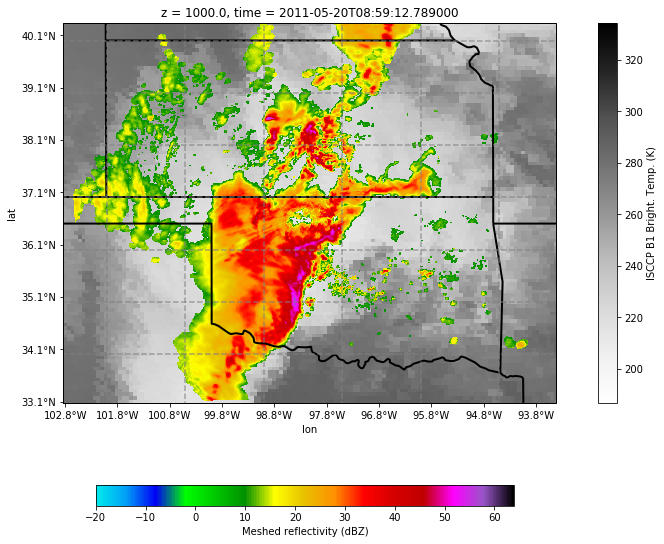

/Users/scollis/anaconda/envs/houston/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-11 15:16:57.962933. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
lat_lines = np.arange(np.around(ds.lat.min(), decimals=1), 
                      ds.lat.max(), 1)
lon_lines = np.arange(np.around(ds.lon.min(),decimals=1),
                      ds.lon.max(), 1)

fig = plt.figure(figsize=[15,10])

my_ax = plt.subplot(projection = ccrs.PlateCarree())

pc_sat = sat.irwin_cdr[0].plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', cmap='Greys', 
                                                add_colorbar=False)

z_var = ds.reflectivity[0].sel(z=1000, method='nearest')
pc = z_var.where(z_var > 10).plot.pcolormesh(transform=ccrs.PlateCarree(), ax=my_ax,
                                                x='lon', y='lat', vmin=-20,
                                                    vmax=64, cmap=pyart.graph.cm.NWSRef,
                                                add_colorbar=False)

cb1 = plt.colorbar(mappable=pc, orientation='horizontal', shrink = 0.5)
cb1.set_label('Meshed reflectivity (dBZ)')
cb2 = plt.colorbar(mappable=pc_sat, orientation='vertical')
cb2.set_label('ISCCP B1 Bright. Temp. (K)')

my_ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
my_ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
my_ax.xaxis.set_major_formatter(lon_formatter)
my_ax.yaxis.set_major_formatter(lat_formatter)
gl = my_ax.gridlines(draw_labels=False,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

political_boundaries = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_0_boundary_lines_land',
                               scale='50m', facecolor='none')

states = cartopy.feature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lines',
                               scale='50m', facecolor='none')

coast = cartopy.feature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

my_ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
my_ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
my_ax.add_feature(coast, linestyle='-', edgecolor='black',linewidth=2)


extent = [ds.lon.min(), ds.lon.max(), ds.lat.min(), ds.lat.max()]
my_ax.set_extent(extent)
plt.savefig('/Users/scollis/grid_sat_z.png')
#request = cimgt.GoogleTiles(style='satellite')
#my_ax.add_image(request, 10, zorder=0)